In [7]:
%matplotlib inline


# 1D optimal transport


This example illustrates the computation of EMD and Sinkhorn transport plans
and their visualization.




HCP dataset: Generate data
-------------



In [1]:
# Author: Remi Flamary <remi.flamary@unice.fr>
#
# License: MIT License

import numpy as np
import matplotlib.pylab as pl
import matplotlib.pyplot as plt

import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import normalize
from scipy.io import loadmat

from scipy.io import loadmat
import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss
import pandas as pd
import random
import scipy.io as sio

import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss
import pandas as pd
import random
from progress.bar import Bar

all_268_mat = sio.loadmat('data/REST1/all_268.mat')
all_368_mat = sio.loadmat('data/REST1/all_368.mat')
all_268 = all_268_mat['data']
all_368 = all_368_mat['data']
from numpy import genfromtxt
all_behav = genfromtxt('data/REST1/IQ.txt', delimiter=',')
all_sex = genfromtxt('data/REST1/gender.txt', delimiter=',')

test_size = 200
train_size = all_268.shape[0]-test_size
random_samples = random.sample(range(0, all_268.shape[0]), all_268.shape[0])
train_index = random_samples[0:train_size]
test_index = random_samples[train_size:]

coord_268 =pd.read_csv('data/REST1/shen_268_matrix.csv', sep=',',header=None)
coord_368 = pd.read_csv('data/REST1/shen_367_matrix.csv', sep=',',header=None)
M = ot.dist(coord_268, coord_368,metric='euclidean')
M /= M.max()


In [12]:
all_368_old = np.zeros((test_size,367,367))
all_268_old = np.zeros((test_size,268,268))

for j in tqdm(range(test_size),"Correlation",ncols=80,position=0):
    all_368_old[j] = corr2_coeff(all_368[test_index][j].T,all_368[test_index][j].T)
    all_268_old[j] = corr2_coeff(all_268[test_index][j].T,all_268[test_index][j].T)


Correlation: 100%|████████████████████████████| 200/200 [22:51<00:00,  6.86s/it]


# Optimal Transport: Intrinsic Evaluation

In [21]:
from tqdm import tqdm
def normalize(x):
    return (x-min(x))/(max(x)-min(x))
num_subj, num_time_points = all_268.shape[:2]

#num_time_points = 1
frame_size = 400
num_frames = num_time_points/frame_size
#pl.figure(3, figsize=(7, 3))
from matplotlib import pyplot as plt
nrow=2
ncol=3
#fig, axes = plt.subplots(ncols=ncol,nrows=nrow, figsize=(20, 10))
G = np.zeros((num_time_points,268,367))

for i in tqdm(range(0,num_time_points,frame_size),"Optimal Transport", ncols = 80, position = 0):#range(num_time_points):
    for j in range(train_size):#(train_size):
        lambd = 1e-3
        a2 = all_268[train_index[j],i,:]
        b2 = all_368[train_index[j],i,:]
        a2 = normalize(a2)+1e-5
        b2 = normalize(b2)+1e-5

        a2= a2/a2.sum(axis=0,keepdims=1)
        b2= b2/b2.sum(axis=0,keepdims=1)
        m = ot.sinkhorn(a2, b2, M, lambd, verbose=False)
        m = m/m.sum(axis=0,keepdims=1)
        G[i:i+frame_size] = G[i:i+frame_size]+ m
    G[i:i+frame_size] = G[i:i+frame_size]/train_size



  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

 33%|███████████████████████████▋                                                       | 1/3 [05:10<10:21, 310.99s/it]

 67%|███████████████████████████████████████████████████████▎                           | 2/3 [10:11<05:07, 307.83s/it]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [15:20<00:00, 306.94s/it]


In [24]:
all_behav_test = all_behav[test_index,]
### TEST ######
from scipy import stats
num_subj, num_time_points = all_268.shape[:2]

def corr2_coeff(A, B):
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:, None]
    B_mB = B - B.mean(1)[:, None]    # Sum of squares across rows
    ssA = (A_mA**2).sum(1)
    ssB = (B_mB**2).sum(1)

    # Finally get corr coeff
    return np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None],ssB[None]))



test_time_series = np.zeros((test_size,num_time_points,367))
#tqdm(range(num_time_points),"All", ncols = 80, position = 0):
for i in tqdm(range(num_time_points),"Timeseries", ncols = 80, position = 0):
    for j in range(test_size):
        a = all_268[test_index[j],i,:]
        b= np.transpose(G[i]).dot(a)
        test_time_series[j,i] = b

all_368_new= np.zeros((test_size,367,367))

for j in tqdm(range(test_size),"Correlation",ncols=80,position=0):
    all_368_new[j] = corr2_coeff(test_time_series[j].T,test_time_series[j].T)
    
from scipy.stats.stats import pearsonr   
results = np.zeros((test_size,2))
for j in  tqdm(range(test_size),"Evaluation",ncols=80,position=0):
    a= all_368_old[j]#corr2_coeff(all_368[train_size+j].T,all_368[train_size+j].T)
    b= all_368_new[j]
    results[j][0] = ((a - b)**2).mean()
    results[j][1] = pearsonr(a.flatten(),b.flatten())[0]
print(np.mean(results, axis=0))
    

Evaluation: 100%|████████████████████████████| 200/200 [00:01<00:00, 120.41it/s]

[0.04151152 0.49402356]


# Connectome based Predictive Modeling

In [4]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import PredefinedSplit
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_regression
from sklearn.pipeline import Pipeline
from sklearn import metrics
from tqdm import tqdm

import numpy as np
import scipy.io as sio
import h5py

import time

# Statistical Testing

In [5]:
from scipy import stats
num_subj, num_time_points = all_268.shape[:2]
def corr2_coeff(A, B):
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:, None]
    B_mB = B - B.mean(1)[:, None]

    # Sum of squares across rows
    ssA = (A_mA**2).sum(1)
    ssB = (B_mB**2).sum(1)

    # Finally get corr coeff
    return np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None],ssB[None]))


all_368_mats = np.zeros((all_368.shape[0],all_368.shape[2],all_368.shape[2]))
all_268_mats = np.zeros((all_268.shape[0],all_268.shape[2],all_268.shape[2]))

for j in tqdm(range(all_268.shape[0]),"Correlation", ncols = 80, position = 0):
    all_368_mats[j] = corr2_coeff(all_368[j].T,all_368[j].T)
    all_268_mats[j] = corr2_coeff(all_268[j].T,all_268[j].T)


Correlation: 100%|████████████████████████████| 876/876 [01:58<00:00,  7.40it/s]


In [34]:
from tqdm import tqdm
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import PredefinedSplit
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn import svm
from time import sleep
import progressbar as pb
from sklearn import linear_model

import numpy as np
import scipy.io as sio
import h5py

import time

def normalize(x):
    return (x-min(x))/(max(x)-min(x))
num_subj, num_time_points = all_268.shape[:2]

num_itr = 92
results = np.zeros((num_itr,2)) # 0: model 1 , 1: model 2
g1 = int(0.25*all_268.shape[0]) # learn OT mapping 
g2 = int(0.5*all_268.shape[0]) # train ML model
g3 = all_268.shape[0]-g1-g2 # test 

model = "SVM"

for itr in tqdm(range(num_itr),"All", ncols = 80, position = 0):
    time.sleep(2)
    random_samples = random.sample(range(0, all_268.shape[0]), all_268.shape[0])
    g1_index = random_samples[0:g1]
    g2_index = random_samples[g1:(g1+g2)]
    g3_index = random_samples[(g1+g2):]

    frame_size = 1200
    num_frames = num_time_points/frame_size
    # gold data on the left out participants
    
    all_368_model_mats = all_368_mats[g2_index]
    all_368_new= np.zeros((g3,367,367))
    all_368_old =all_368_mats[g3_index] 
    all_268_old =all_268_mats[g3_index] 
    # CHANGE THIS TO TEST
    all_mats_1 = all_368_old # g3
    all_mats_2 = all_368_new # g3 ALWAYS NEW
    
    #np.random.shuffle(g2_index)
    sex=1
    if sex:
        all_behav_g2 = all_sex[g2_index,]
        all_behav_g3 = all_sex[g3_index,]
    else:
        all_behav_g2 = all_behav[g2_index,]
        all_behav_g3 = all_behav[g3_index,]
    #np.random.shuffle(all_behav_g2) ## FOR NULL MODEL
    
    # OPTIMAL TRANSPORT
    if not all_mats_1.any() or not all_mats_2.any():
        G = np.zeros((num_time_points,268,367))
        for i in range(0,num_time_points,frame_size):#range(num_time_points):
            for j in range(g1):#(train_size):
                lambd = 1e-3
                a2 = all_268[g1_index[j],i,:]
                b2 = all_368[g1_index[j],i,:]
                a2 = normalize(a2)+1e-5
                b2 = normalize(b2)+1e-5
                a2= a2/a2.sum(axis=0,keepdims=1)
                b2= b2/b2.sum(axis=0,keepdims=1)
                m = ot.sinkhorn(a2, b2, M, lambd, verbose=False)
                m = m/m.sum(axis=0,keepdims=1)
                G[i:i+frame_size] = G[i:i+frame_size]+ m
            G[i:i+frame_size] = G[i:i+frame_size]/g1
        test_time_series = np.zeros((g3,num_time_points,367))
        for i in range(num_time_points):
            for j in range(g3):
                a = all_268[g3_index[j],i,:]
                b= np.transpose(G[i]).dot(a)
                test_time_series[j,i] = b

        for j in range(g3):
            all_mats_2[j] = corr2_coeff(test_time_series[j].T,test_time_series[j].T)

    num_node = np.shape(all_mats_1)[1]
    num_sub_g2 = np.shape(all_368_model_mats)[0]
    num_sub_g3 = np.shape(all_mats_1)[0]
    num_task = 1
    num_edge = num_node * (num_node-1) // 2
    num_edge_total = num_edge * num_task

    all_edges_g2 = np.zeros([num_edge, num_sub_g2, num_task])
    all_edges_g3_1 = np.zeros([num_edge, num_sub_g3, num_task])
    all_edges_g3_2 = np.zeros([num_edge, num_sub_g3, num_task])

    iu1 = np.triu_indices(num_node, 1)
    for i in range(num_sub_g2):
        for j in range(num_task):
            all_edges_g2[:, i, j] = all_368_model_mats[i, iu1[0], iu1[1]]

    for i in range(num_sub_g3):
        for j in range(num_task):
                all_edges_g3_1[:, i, j] = all_mats_1[i, iu1[0], iu1[1]]
                all_edges_g3_2[:, i, j] = all_mats_2[i, iu1[0], iu1[1]]
                    
    all_edges_g2 = np.transpose(all_edges_g2, (2, 0, 1))
    all_edges_g2 = np.reshape(all_edges_g2, [-1, num_sub_g2])

    all_edges_g3_1 = np.transpose(all_edges_g3_1, (2, 0, 1))
    all_edges_g3_1 = np.reshape(all_edges_g3_1, [-1, num_sub_g3])
    all_edges_g3_2 = np.transpose(all_edges_g3_2, (2, 0, 1))
    all_edges_g3_2 = np.reshape(all_edges_g3_2, [-1, num_sub_g3])
       
    if  sex:
        clf = svm.SVC(kernel='linear', C=1).fit(all_edges_g2.T, all_behav_g2)
        s1 = clf.score(all_edges_g3_1.T, all_behav_g3)
        s2 = clf.score(all_edges_g3_2.T, all_behav_g3)
        results[itr,0] = s1
        results[itr,1]= s2    
    else:
        clf = linear_model.Lasso(alpha=0.1)
        clf.fit (all_edges_g2.T, all_behav_g2)
        all_pred_1 = clf.predict(all_edges_g3_1.T)
        all_pred_2 = clf.predict(all_edges_g3_2.T)
        s1 = np.corrcoef(all_pred_1.T, all_behav_g3.T)[0, 1]
        s2 = np.corrcoef(all_pred_2.T, all_behav_g3.T)[0, 1]
        results[itr,0] = s1
        results[itr,1]= s2
        

All:  58%|███████████████████              | 53/92 [3:26:57<2:34:14, 237.31s/it]

KeyboardInterrupt: 

In [15]:
print(results[0])

[0.26059083 0.21145753]


In [64]:
#(file="null.png",)
results_368_new_g3 = c(0.15, 0.105, 0.113, 0.184, 0.257, 0.212, 0.189, 0.246, 0.197, 0.119, 0.149, 0.125, 0.138, 0.086, 0.067, 0.135, 0.238, 0.2, 0.104, 0.082, 0.087, 0.112, 0.17, 0.153, 0.152, 0.237, 0.202, 0.043, 0.248, 0.184, 0.088, 0.214, 0.123, 0.077, 0.173, 0.1, 0.237, 0.129, 0.136, 0.09, 0.133, 0.186, 0.035, 0.122, 0.078, 0.153, 0.121, 0.248, 0.109, 0.184, 0.056, 0.084, 0.222, 0.202, 0.162, 0.19, 0.133, 0.292, 0.112, 0.171, 0.235, 0.2, 0.265, 0.061, 0.149, 0.179, 0.218, 0.113, 0.172, 0.21, 0.248, 0.225, 0.032, 0.086, 0.182, 0.08, 0.301, 0.141, 0.133, 0.139, 0.109, 0.168, 0.161, 0.18, 0.188, 0.123, 0.186, 0.22, 0.061, 0.235, 0.173, 0.152, 0.078, 0.126, 0.155, 0.247, 0.084, 0.223, 0.131, 0.116)

results_368_old_g3 = c(0.2, 0.199, 0.12, 0.228, 0.315, 0.304, 0.25, 0.258, 0.288, 0.208, 0.178, 0.273, 0.133, 0.165, 0.142, 0.221, 0.25, 0.222, 0.18, 0.185, 0.17, 0.155, 0.187, 0.222, 0.184, 0.225, 0.215, 0.16, 0.294, 0.34, 0.126, 0.283, 0.138, 0.133, 0.2, 0.124, 0.247, 0.13, 0.26, 0.115, 0.197, 0.276, 0.109, 0.194, 0.195, 0.192, 0.245, 0.289, 0.154, 0.131, 0.17, 0.11, 0.156, 0.267, 0.206, 0.309, 0.186, 0.223, 0.221, 0.189, 0.299, 0.245, 0.078, 0.184, 0.246, 0.292, 0.309, 0.127, 0.199, 0.182, 0.275, 0.221, 0.06, 0.142, 0.275, 0.115, 0.313, 0.233, 0.179, 0.235, 0.109, 0.17, 0.266, 0.275, 0.233, 0.161, 0.201, 0.261, 0.107, 0.338, 0.163, 0.205, 0.2, 0.129, 0.141, 0.295, 0.119, 0.243, 0.173, 0.234)
results_368_null_g3 = c(-0.006, 0.024, 0.058, -0.065, -0.04, -0.012, -0.122, -0.092, 0.101, -0.031, 0.155, 0.178, -0.0, -0.121, -0.048, -0.084, -0.124, 0.185, -0.191, 0.047, -0.096, -0.113, -0.093, -0.086, -0.017, 0.109, -0.132, 0.162, 0.114, -0.07, -0.054, -0.119, -0.065, -0.166, -0.171, 0.019, -0.007, -0.07, 0.061, 0.074, 0.034, 0.075, 0.008, 0.064, 0.094, 0.23, 0.082, -0.055, 0.144, 0.035, 0.021, -0.164, 0.0, 0.069, -0.126, 0.089, 0.104, -0.084, -0.019, 0.1, 0.047, -0.024, 0.097, -0.061, 0.083, 0.168, 0.125, -0.036, -0.106, -0.006, 0.178, -0.094, 0.01, -0.023, 0.033, -0.123, 0.042, 0.119, -0.132, 0.097, 0.069, 0.038, 0.091, -0.007, 0.072, 0.054, -0.145, 0.023, 0.158, -0.03, 0.093, -0.055, -0.064, -0.026, 0.207, 0.157, -0.108, 0.02, 0.151, -0.058)

results_368_new_sex_svm_g3 = c(0.721, 0.767, 0.689, 0.667, 0.671, 0.584, 0.735, 0.712, 0.689, 
                                0.694, 0.726, 0.717, 0.703, 0.708, 0.658, 0.653, 0.607, 0.744, 
                                0.749, 0.639, 0.676, 0.685, 0.749, 0.653, 0.731, 0.68, 0.758, 
                                0.685, 0.74, 0.721, 0.767, 0.726, 0.662, 0.635, 0.744, 0.767, 
                                0.694, 0.63, 0.667, 0.639, 0.699, 0.721, 0.721, 0.712, 0.621, 
                                0.708, 0.74, 0.703, 0.689, 0.721, 0.653, 0.685, 0.731, 0.689, 
                                0.699, 0.717, 0.726, 0.68, 0.658, 0.667, 0.708, 0.815951812714417, 
                                0.61870925022329, 0.636087263610863, 0.638235675495763, 0.744537405373365, 
                                0.706150311214133, 0.599456228390433, 0.733665375487829, 0.635144555650054, 
                                0.737349724274552, 0.778837746425938, 0.711682805027565, 0.679061518175161, 
                                0.700838745338957, 0.732962748548225, 0.688183790106866, 0.73940008707225, 
                                0.664916875805256, 0.709090432933067, 0.590603564258221, 0.762218738285041, 
                                0.752204411036652, 0.693204889920263, 0.718990677681521, 0.589565098798473, 
                                0.660629741958109, 0.720713687992185, 0.716758122310139, 0.776835632244678, 
                                0.656331382522653, 0.712002192031819, 0.773311218003026, 0.702877216075771, 
                                0.670482874192944, 0.654646843851561, 0.693656566063778, 0.706232457285578, 
                                0.655010973302008, 0.641994922078296)

results_368_old_sex_svm_g3 = c(0.863, 0.877, 0.863, 0.858, 0.817, 0.84, 0.863, 0.854, 0.84, 
                                0.836, 0.863, 0.868, 0.877, 0.808, 0.831, 0.863, 0.868, 0.845, 
                                0.872, 0.849, 0.845, 0.854, 0.886, 0.872, 0.854, 0.854, 0.877, 
                                0.872, 0.877, 0.881, 0.868, 0.849, 0.904, 0.881, 0.895, 0.868, 
                                0.84, 0.858, 0.89, 0.845, 0.849, 0.89, 0.868, 0.877, 0.895, 0.858, 
                                0.895, 0.868, 0.895, 0.826, 0.881, 0.877, 0.886, 0.836, 0.854, 
                                0.849, 0.854, 0.831, 0.872, 0.886, 0.872, 0.901148148131783, 
                                0.868102727047618, 0.882368191117957, 0.776725485771074, 0.919309119344985, 
                                0.824071185288523, 0.817125049512812, 0.924867024533235, 0.880506427889279, 
                                0.907108746988478, 0.862906753705657, 0.897024624849362, 0.88420946022264, 
                                0.869330499723864, 0.854850958906867, 0.920028512737234, 0.814043706466349, 
                                0.805283011627652, 0.868768906384409, 0.869335604234583, 0.87036439116023, 
                                0.866931545695029, 0.843135010276824, 0.867954631912822, 0.904408452981909, 
                                0.890124971157021, 0.877668723504836, 0.820187602519329, 0.83331832454279, 
                                0.819004109249115, 0.906242450168415, 0.808512647507702, 0.876264797545176, 
                                0.847755425960067, 0.815388517776489, 0.882774513788296, 0.820616587830122, 
                                0.800653189392478, 0.797807938285446)

results_368_null_sex_svm_g3 = c(0.516, 0.429, 0.466, 0.475, 0.53, 0.434, 0.557, 0.584, 0.525, 0.489, 0.543, 0.562, 0.461, 0.502, 0.493, 0.516, 0.548, 0.489, 0.507, 0.511, 0.447, 0.479, 0.566, 0.521, 0.489, 0.457, 0.489, 0.443, 0.489, 0.575, 0.47, 0.516, 0.516, 0.461, 0.47, 0.516, 0.484, 0.557, 0.493, 0.534, 0.511, 0.534, 0.452, 0.47, 0.498, 0.493, 0.461, 0.521, 0.516, 0.516, 0.516, 0.543, 0.58, 0.534, 0.466, 0.575, 0.47, 0.594, 0.53, 0.438, 0.489, 0.461, 0.489, 0.521, 0.539, 0.452, 0.511, 0.42, 0.493, 0.525, 0.502, 0.479, 0.493, 0.516, 0.498, 0.589, 0.484, 0.525, 0.466, 0.516, 0.447, 0.461, 0.548, 0.53, 0.548, 0.548, 0.411, 0.53, 0.53, 0.452, 0.47, 0.498, 0.507, 0.493, 0.457, 0.516, 0.562, 0.598, 0.438, 0.489)

#pnorm(q, mean = 0, sd = 1)
# b<- sample(results_368_old_sex_svm_g3, 39,replace=FALSE)
# a <- c(results_368_old_sex_svm_g3,b+rnorm(39, mean=0, sd=0.03))
# length(a)
# dput(a)
c1 <- rgb(255,255,255,max = 255, alpha = 80, names = "lt.blue")
c2 <- rgb(0,0,255, max = 255, alpha = 90, names = "lt.pink")

pdf(file = "null_876.pdf")
a <- results_368_null_g3
b <- results_368_new_g3
length(b)
hg1=hist(a,plot = FALSE)
hg2 =hist(b,plot = FALSE)
plot(hg1, col = "white",main ="" ,xlab="Pearson",cex.lab=1.5,xlim=c(-0.1,0.4),ylim=c(0,40))
abline(v=mean(a),col="red",lwd=1)
plot(hg2, col = c2, add = TRUE,main="Main title")
#abline(v=mean(b),col="black",lwd=1)
dev.off()


[1] 100

png 
  2

# IQ prediction

Saving 6.67 x 6.67 in image



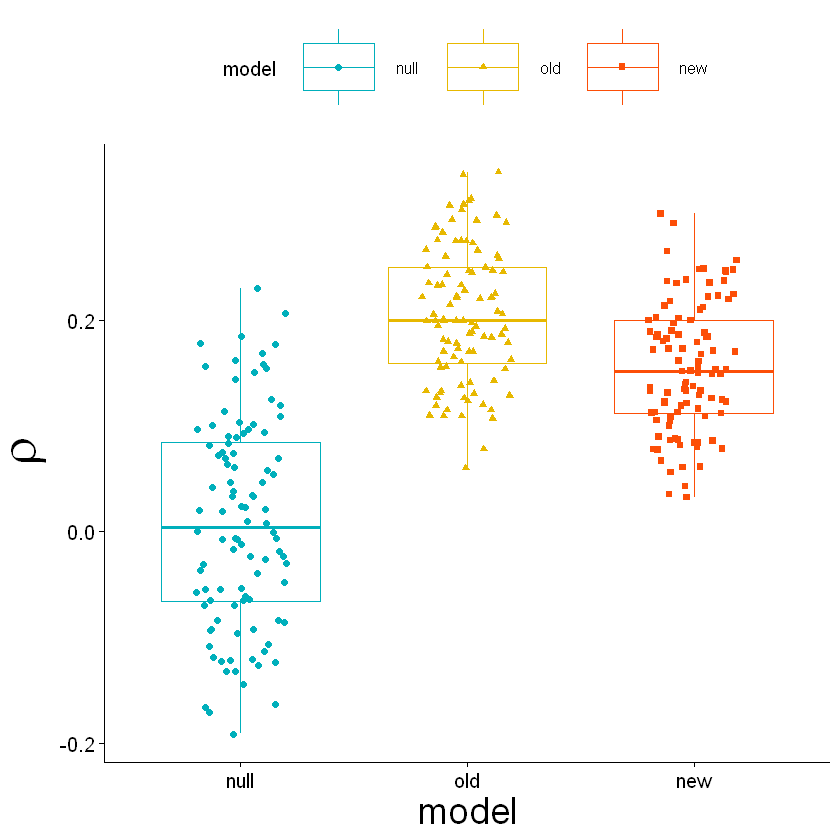

In [12]:
library(ggpubr)



df_results_368_null_g3 <- data.frame(pearson=results_368_null_g3,model=rep("null",length(results_368_new_g3)))
df_results_368_old_g3 <- data.frame(pearson=results_368_old_g3,model=rep("old",length(results_368_new_g3)))
df_results_368_new_g3 <- data.frame(pearson=results_368_new_g3,model=rep("new",length(results_368_new_g3)))

df_results_368_g3 <-rbind(df_results_368_null_g3,df_results_368_old_g3,df_results_368_new_g3)


p <- ggboxplot(df_results_368_g3, x = "model", y = "pearson",
               color = "model", palette =c("#00AFBB", "#E7B800","#FC4E07"),
               add = "jitter", ylab=expression(rho),shape = "model")

#tail(df_results_368)
p+font("xlab", size = 22)+font("ylab", size = 32)+theme(legend.key.width= unit(2, 'cm'))+theme(legend.key.height= unit(2, 'cm'))
ggsave("rcpm_iq_876.pdf")
#packageVersion("rlang")
#R.Version()

# Sex Classification: SVM

Saving 6.67 x 6.67 in image



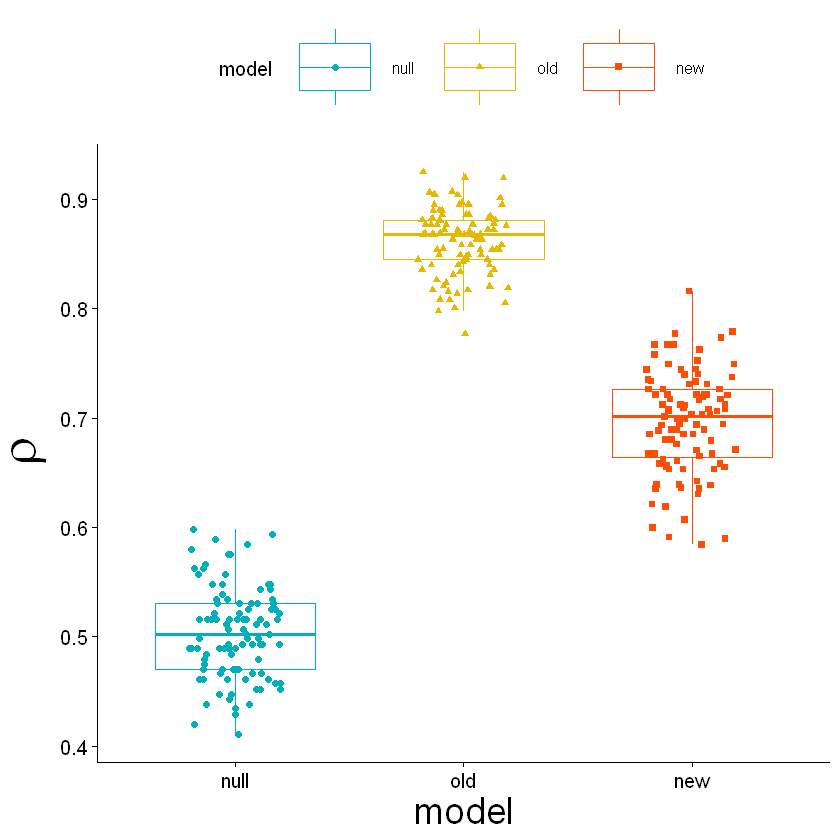

In [27]:
df_results_368_old_sex_svm_g3 <- data.frame(pearson=results_368_old_sex_svm_g3,model=rep("old",length(results_368_new_sex_svm_g3)))
df_results_368_new_sex_svm_g3 <- data.frame(pearson=results_368_new_sex_svm_g3,model=rep("new",length(results_368_new_sex_svm_g3)))
df_results_368_null_sex_svm_g3 <- data.frame(pearson=results_368_null_sex_svm_g3,model=rep("null",length(results_368_new_sex_svm_g3)))
df_results_368_sex_svm_g3 <-rbind(df_results_368_null_sex_svm_g3,df_results_368_old_sex_svm_g3,df_results_368_new_sex_svm_g3)


p <- ggboxplot(df_results_368_sex_svm_g3, x = "model", y = "pearson",
               color = "model", palette =c("#00AFBB", "#E7B800","#FC4E07"),
               add = "jitter", ylab=TeX('$\\rho$'),shape = "model")

p+font("xlab", size = 22)+font("ylab", size = 32)+theme(legend.key.width= unit(2, 'cm'))+theme(legend.key.height= unit(2, 'cm'))
ggsave("svm_sex_876.pdf")

In [12]:
t.test(results_368_new_sex_svm, results_368_old_sex_svm, alternative = "two.sided", var.equal = FALSE,paired =TRUE)


	Paired t-test

data:  results_368_new_sex_svm and results_368_old_sex_svm
t = -3.4325, df = 99, p-value = 0.0008744
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.0473422 -0.0126578
sample estimates:
mean of the differences 
                  -0.03 


In [13]:
t.test(results_368_new, results_368_old, alternative = "two.sided", var.equal = FALSE,paired =TRUE)


	Paired t-test

data:  results_368_new and results_368_old
t = -1.9084, df = 58, p-value = 0.0613
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.05532596  0.00132097
sample estimates:
mean of the differences 
            -0.02700249 


In [36]:
print([round(i[1],3) for i in results])

[0.689, 0.694, 0.726, 0.717, 0.703, 0.708, 0.658, 0.653, 0.607, 0.744, 0.749, 0.639, 0.676, 0.685, 0.749, 0.653, 0.731, 0.68, 0.758, 0.685, 0.74, 0.721, 0.767, 0.726, 0.662, 0.635, 0.744, 0.767, 0.694, 0.63, 0.667, 0.639, 0.699, 0.721, 0.721, 0.712, 0.621, 0.708, 0.74, 0.703, 0.689, 0.721, 0.653, 0.685, 0.731, 0.689, 0.699, 0.717, 0.726, 0.68, 0.658, 0.667, 0.708, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [38]:
print(len(results_368_new_sex_svm_g3))

NameError: name 'results_368_new_sex_svm_g3' is not defined

# Resampled T-test

In [24]:
a= results_368_null_g3
b = results_368_old_g3
n=length(results_368_new_sex_svm_g3)
diff = a - b
s2= sd(diff)
avg = mean(diff)
t = diff[1]/s2
p = 2*pt(-abs(t),df=n-1)
p

[1] 0.08631231

In [1]:
diff_new_old_abs=c(0.115, 0.051, 0.145, 0.178, 0.016, 0.021, 0.076, 0.038, 0.145, 0.05, 0.056, 0.019, 0.037, 0.036, 0.01, 0.023, 0.024, 0.199, 0.183, 0.059, 0.105, 0.01, 0.085, 0.094, 
  0.029, 0.001, 0.037, 0.079, 0.038, 0.028, 0.043, 0.037, 0.066, 0.048, 0.053, 0.061, 0.221, 0.027, 0.002, 0.012, 0.033, 0.051, 0.078, 0.005, 0.005, 0.123, 0.044, 0.05, 0.017,
  0.096, 0.023, 0.085, 0.001, 0.229, 0.033, 0.047, 0.07, 0.017, 0.039, 0.011, 0.031, 0.113, 0.016, 0.113, 0.243, 0.146, 0.082, 0.012, 0.057, 0.044, 0.055, 0.225, 0.078, 0.069,
  0.101, 0.022, 0.062, 0.026, 0.069, 0.027, 0.021, 0.078, 0.033, 0.011, 0.048, 0.142, 0.23, 0.062, 0.007, 0.077, 0.031, 0.05, 0.107, 0.079, 0.019, 0.051, 0.142, 0.101, 0.05, 0.01)
diff_new_old_sex_svm_abs = c(0.153, 0.252, 0.168, 0.198, 0.16, 0.137, 0.153, 0.275, 0.244, 0.145, 0.206, 0.298, 0.29, 0.183, 0.282, 0.076, 0.176, 0.229, 0.328, 0.26, 0.252, 0.0, 0.198,
                         0.076, 0.191, 0.191, 0.168, 0.115, 0.191, 0.252, 0.122, 0.13, 0.198, 0.29, 0.053, 0.122, 0.191, 0.115, 0.191, 0.137, 0.183, 0.115, 0.275, 0.221, 0.183, 0.221,
                         0.221, 0.244, 0.069, 0.176, 0.305, 0.198, 0.275, 0.115, 0.198, 0.168, 0.115, 0.176, 0.168, 0.099, 0.145, 0.16, 0.076, 0.328, 0.221, 0.137, 0.183, 0.214, 0.221,
                         0.214, 0.137, 0.267, 0.282, 0.214, 0.092, 0.145, 0.229, 0.214, 0.137, 0.069, 0.298, 0.298, 0.191, 0.229, 0.115, 0.198, 0.229, 0.221, 0.13, 0.092, 0.099, 0.198,
                         0.244, 0.252, 0.145, 0.198, 0.267, 0.305, 0.145, 0.275)
diff_new_old_sex_svm = c(0.145, 0.122, 0.206, 0.122, 0.145, 0.237, 0.183, 0.214, 0.237, 0.305, 0.221, 0.183, 0.16, 0.16, 0.153, 0.221, 0.29, 0.191, 0.26, 0.183, 0.122, 0.046, 0.153,
                         0.153, 0.198, 0.229, 0.244, 0.206, 0.168, 0.16, 0.282, 0.206, 0.122, 0.252, 0.153, 0.221, 0.099, 0.16, 0.252, 0.321, 0.16, 0.237, 0.13, 0.13, 0.084, 0.145, 0.13, 
                         0.13, 0.221, 0.237, 0.191, 0.153, 0.145, 0.275, 0.221, 0.305, 0.275, 0.099, 0.229, 0.168, 0.305, 0.137, 0.137, 0.229, 0.153, 0.099, 0.244, 0.29, 0.153, 0.244, 0.153, 
                         0.13, 0.16, 0.099, 0.183, 0.099, 0.26, 0.183, 0.214, 0.092, 0.145, 0.237, 0.107, 0.221, 0.122, 0.298, 0.145, 0.252, 0.153, 0.221, 0.115, 0.13, 0.145, 0.26, 0.298,
                         0.214, 0.328, 0.237, 0.153, 0.191)
diff_new_old_iq = c(0.099, 0.002, 0.093, -0.079, 0.112, -0.005, 0.025, 0.107, -0.003, -0.11, 0.141, -0.002, -0.063, 0.116, 0.026, -0.126, 0.067, -0.007, -0.061, 0.051, 0.043, 0.133, -0.015,
                    -0.079, 0.035, -0.04, -0.003, 0.003, 0.045, 0.11, 0.161, 0.187, -0.001, 0.106, 0.064, -0.116, 0.085, 0.036, -0.009, 0.051, 0.052, 0.072, -0.045, -0.005, -0.159, 0.148, -0.053, 
                    -0.026, 0.055, 0.026, -0.056, 0.088, 0.014, 0.087, 0.036, 0.035, 0.11, 0.099, 0.013, 0.09, -0.128, 0.015, -0.051, 0.082, 0.009, 0.076, 0.009, 0.194, -0.01, 0.162, 0.12, -0.046,
                    0.138, -0.053, 0.162, 0.079, 0.096, 0.134, 0.115, 0.021, 0.15, 0.067, 0.033, 0.045, 0.157, -0.091, 0.116, -0.065, 0.042, -0.022, -0.039, -0.122, 0.079, 0.047, 0.017, 0.102, 0.034,
                    0.003, 0.032, 0.082)
#t.test(diff_new_old, mu = 0, alternative = "two.sided")

diff = diff_new_old_iq
n=length(diff)
s2= sd(diff)
t = diff[1]/s2
p = 2*pt(-abs(t),df=n-1)
p

[1] 0.2044117

In [33]:
print([round(i[1],3) for i in results])

[0.721, 0.767, 0.689, 0.667, 0.671, 0.584, 0.735, 0.712, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
